In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import imageio
from imageio import imread
import shutil
import pandas as pd
import pickle
from tqdm import tqdm_notebook, tqdm
from sklearn.model_selection import train_test_split
from pylab import rcParams
import sys
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix
import cv2
%matplotlib inline

In [2]:
fake_path = 'training/fake/'
pristine_path = 'training/pristine/'
mask_path = fake_path + 'masks/'

In [5]:
# segregate masks from images
if not os.path.isdir(fake_path+'masks/'):
    os.mkdir(fake_path+'masks/')
    for fake in fakes:
        if len(fake.split('.'))==3:
            shutil.move(fake_path+fake, fake_path+'masks/')
else:
    print('Segregated already')

Segregated already


In [3]:
fakes = os.listdir(fake_path)[1:-1]

In [4]:
masks = os.listdir(mask_path)

In [5]:
pristines = os.listdir(pristine_path)

# Pickle Based On Images Channel

## Fakes

All images have 4 or 3 channels

In [9]:
four_channel_fakes=[]
for fake in fakes:
    if imageio.imread(fake_path+fake).shape[2]==4:
        four_channel_fakes.append(fake)
        
three_channel_fakes = [f for f in fakes if f not in four_channel_fakes]

In [10]:
len(four_channel_fakes)

64

In [11]:
len(three_channel_fakes)

386

In [51]:
with open('pickle/channels/three_channel_fakes.pickle', 'wb') as f:
    pickle.dump(three_channel_fakes, f)
    
with open('pickle/channels/four_channel_fakes.pickle', 'wb') as f:
    pickle.dump(four_channel_fakes, f)

## Masks

One, three, or four channels

In [14]:
one_channel_masks=[]
for mask in masks:
    if len(imageio.imread(mask_path+mask).shape)==2:
        one_channel_masks.append(mask)

In [16]:
three_channel_masks=[]
for mask in masks:
    img=imageio.imread(mask_path+mask)
    if len(img.shape)==3 and img.shape[2]==3:
        three_channel_masks.append(mask)

four_channel_masks=[m for m in masks if ((m not in one_channel_masks) and (m not in three_channel_masks))]

In [17]:
len(three_channel_masks)

65

In [18]:
len(four_channel_masks)

58

In [19]:
print(str(len(one_channel_masks))+' masks have only one channel i.e. grayscale')

327 masks have only one channel i.e. grayscale


In [52]:
with open('pickle/channels/one_channel_masks.pickle', 'wb') as f:
    pickle.dump(one_channel_masks, f)
    
with open('pickle/channels/three_channel_masks.pickle', 'wb') as f:
    pickle.dump(three_channel_masks, f)
    
with open('pickle/channels/four_channel_masks.pickle', 'wb') as f:
    pickle.dump(four_channel_masks, f)

## Pristines

One, three, or four channels

In [24]:
three_channel_pristines=[]

for pristine in pristines:
    img=imageio.imread(pristine_path+pristine)
    if len(img.shape)==3 and img.shape[2]==3:
        three_channel_pristines.append(pristine)

In [25]:
one_channel_pristines=[]

for pristine in pristines:
    img=imageio.imread(pristine_path+pristine)
    if len(img.shape)<3:
        one_channel_pristines.append(pristine)
    
four_channel_pristines=[p for p in pristines if (p not in one_channel_pristines) and (p not in three_channel_pristines)]

In [26]:
len(three_channel_pristines)

1025

In [27]:
len(one_channel_pristines)

3

In [28]:
len(four_channel_pristines)

22

In [50]:
with open('pickle/channels/one_channel_pristines.pickle', 'wb') as f:
    pickle.dump(one_channel_pristines, f)
    
with open('pickle/channels/three_channel_pristines.pickle', 'wb') as f:
    pickle.dump(three_channel_pristines, f)

with open('pickle/channels/four_channel_pristines.pickle', 'wb') as f:
    pickle.dump(four_channel_pristines, f)

## Channel Distribution

In [31]:
table={}
table['pristines']=[len(one_channel_pristines), len(three_channel_pristines), len(four_channel_pristines), len(one_channel_pristines)+len(three_channel_pristines)+len(four_channel_pristines)]
table['fakes']=[0, len(three_channel_fakes), len(four_channel_fakes), len(three_channel_fakes)+len(four_channel_fakes)]
table['masks']=[len(one_channel_masks), len(three_channel_masks), len(four_channel_masks), len(one_channel_masks)+len(three_channel_masks)+len(four_channel_masks)]
pd.DataFrame(table, index=['1 channel', '3 channel', '4 channel', 'total'])

,pristines,fakes,masks
1 channel,3,0,327
3 channel,1025,386,65
4 channel,22,64,58
total,1050,450,450


# Pickle Based On Training Data

## Training Data Preparation

In [6]:
pristine_images=[]
pristines_final=[]
for i, pristine in enumerate(pristines):
    img=imread(pristine_path+pristine)
    if len(img.shape)<3:
        continue
    if img.shape[2]==4:
        continue
    pristines_final.append(pristine)
    pristine_images.append(img)

In [7]:
len(pristines_final)

1025

In [8]:
fake_images=[]
fakes_final=[]
for fake in fakes:
    img=imread(fake_path+fake)
    try:
        fake_images.append(img[:,:,:3])
        fakes_final.append(fake)
    except IndexError:
        print(f'image {fake} has only 1 channel')

In [9]:
len(fake_images)

450

==================CHECK ONLY==============================

In [12]:
image_names=[]
for i in range(0, 5):
    image_names.append(pristines_final[i])
for i in range(0, 5):
    image_names.append(fakes_final[i])

In [13]:
image_names

['0001d52e2fd94f30c2bca0449763a752.png',
 '000bc3906100ede4b1374cea075adedb.png',
 '002e23c036a05de656242f5ce6ab2e15.png',
 '003f2d6e572e2587ffa809f78ff4a5c4.png',
 '00d56bffe2d757a4e4625cc2d0bd0de9.png',
 '010543abfbd0db1e9aa1b24604336e0c.png',
 '022354380a1a17ff49226c9eae21a11f.png',
 '0294345b3b2324b195cb3b30e91d7678.png',
 '0363353570f16ff0a73aa0a03a7795b8.png',
 '0830004e471e511458600f0763ce19f3.png']

In [14]:
labels=[0]*5+[1]*5

In [15]:
x_train, x_test, y_train, y_test = train_test_split(image_names, labels, test_size=0.2, stratify=labels)

In [18]:
x_train

['0363353570f16ff0a73aa0a03a7795b8.png',
 '00d56bffe2d757a4e4625cc2d0bd0de9.png',
 '0294345b3b2324b195cb3b30e91d7678.png',
 '0001d52e2fd94f30c2bca0449763a752.png',
 '022354380a1a17ff49226c9eae21a11f.png',
 '000bc3906100ede4b1374cea075adedb.png',
 '010543abfbd0db1e9aa1b24604336e0c.png',
 '003f2d6e572e2587ffa809f78ff4a5c4.png']

In [19]:
y_train

[1, 0, 1, 0, 1, 0, 1, 0]

In [20]:
x_train_images=[]
for x in x_train:
    try:
        img=imread(pristine_path+x)
    except FileNotFoundError:
        img=imread(fake_path+x)
    
    x_train_images.append(img)

In [21]:
x_train_mask_names=[]
for ind, x in enumerate(x_train):
    if y_train[ind]==1:
        x_train_mask_names.append(x.split('.')[0]+'.mask.png')

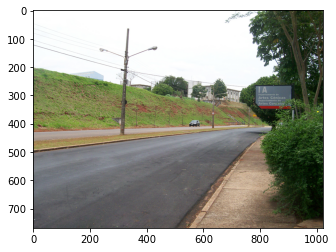

In [26]:
plt.imshow(x_train_images[4])

In [27]:
x_train_mask_names

['0363353570f16ff0a73aa0a03a7795b8.mask.png',
 '0294345b3b2324b195cb3b30e91d7678.mask.png',
 '022354380a1a17ff49226c9eae21a11f.mask.png',
 '010543abfbd0db1e9aa1b24604336e0c.mask.png']

In [28]:
x_train_fakes_names=[]
x_train_fake_images=[]
for ind, x in enumerate(x_train):
    if y_train[ind]==1:
        x_train_fakes_names.append(x)
        x_train_fake_images.append(x_train_images[ind])

In [29]:
x_train_fakes_names

['0363353570f16ff0a73aa0a03a7795b8.png',
 '0294345b3b2324b195cb3b30e91d7678.png',
 '022354380a1a17ff49226c9eae21a11f.png',
 '010543abfbd0db1e9aa1b24604336e0c.png']

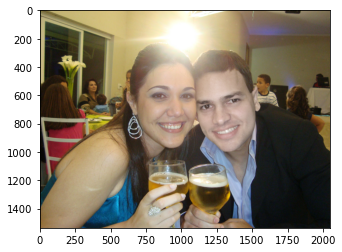

In [39]:
plt.imshow(x_train_fake_images[3])

In [30]:
x_train_pristines_names=[]
x_train_pristine_images=[]
for ind, x in enumerate(x_train):
    if y_train[ind]==0:
        x_train_pristines_names.append(x)
        x_train_pristine_images.append(x_train_images[ind])

In [31]:
x_train_pristines_names

['00d56bffe2d757a4e4625cc2d0bd0de9.png',
 '0001d52e2fd94f30c2bca0449763a752.png',
 '000bc3906100ede4b1374cea075adedb.png',
 '003f2d6e572e2587ffa809f78ff4a5c4.png']

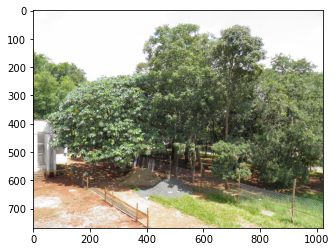

In [43]:
plt.imshow(x_train_pristine_images[3])

In [44]:
x_train_masks=[]
for m in x_train_mask_names:
    
    img=imread(mask_path+m)
    
    if len(img.shape)>2:
        img=img[:,:,0]
        
    x_train_masks.append(img)

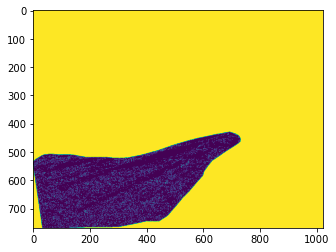

In [48]:
plt.imshow(x_train_masks[2])

==================CHECK ONLY==============================

In [49]:
image_names=[]
for i in range(0, len(pristine_images)):
    image_names.append(pristines_final[i])
for i in range(0, len(fake_images)):
    image_names.append(fakes_final[i])

In [50]:
len(image_names)

1475

In [51]:
labels=[0]*1025+[1]*450

In [52]:
x_train, x_test, y_train, y_test = train_test_split(image_names, labels, test_size=0.2, stratify=labels)

In [53]:
x_train_images=[]
for x in x_train:
    try:
        img=imread(pristine_path+x)
    except FileNotFoundError:
        img=imread(fake_path+x)
    
    x_train_images.append(img)

In [44]:
x_train_mask_names=[]
for ind, x in enumerate(x_train):
    if y_train[ind]==1:
        x_train_mask_names.append(x.split('.')[0]+'.mask.png')

In [45]:
x_train_fakes_names=[]
x_train_fake_images=[]
for ind, x in enumerate(x_train):
    if y_train[ind]==1:
        x_train_fakes_names.append(x)
        x_train_fake_images.append(x_train_images[ind])

In [46]:
x_train_pristines_names=[]
x_train_pristine_images=[]
for ind, x in enumerate(x_train):
    if y_train[ind]==0:
        x_train_pristines_names.append(x)
        x_train_pristine_images.append(x_train_images[ind])

In [47]:
x_train_masks=[]
for m in x_train_mask_names:
    
    img=imread(mask_path+m)
    
    if len(img.shape)>2:
        img=img[:,:,0]
        
    x_train_masks.append(img)

## Mask Images

Save setiap image mask dipisah" jadi 9 file pickle masing" nyimpen 40 file image masks

In [54]:
with open('pickle/images/x_train_masks_0.pickle', 'wb') as f:
    pickle.dump(x_train_masks[:40], f)
with open('pickle/images/x_train_masks_1.pickle', 'wb') as f:
    pickle.dump(x_train_masks[40:80], f)
with open('pickle/images/x_train_masks_2.pickle', 'wb') as f:
    pickle.dump(x_train_masks[80:120], f)    
with open('pickle/images/x_train_masks_3.pickle', 'wb') as f:
    pickle.dump(x_train_masks[120:160], f)
with open('pickle/images/x_train_masks_4.pickle', 'wb') as f:
    pickle.dump(x_train_masks[160:200], f)
with open('pickle/images/x_train_masks_5.pickle', 'wb') as f:
    pickle.dump(x_train_masks[200:240], f)
with open('pickle/images/x_train_masks_6.pickle', 'wb') as f:
    pickle.dump(x_train_masks[240:280], f)
with open('pickle/images/x_train_masks_7.pickle', 'wb') as f:
    pickle.dump(x_train_masks[280:320], f)
with open('pickle/images/x_train_masks_8.pickle', 'wb') as f:
    pickle.dump(x_train_masks[320:360], f)

## Fake Names

In [55]:
with open('pickle/images_names/x_train_fakes_names.pickle', 'wb') as f:
    pickle.dump(x_train_fakes_names, f)

## Mask Names

In [56]:
with open('pickle/images_names/x_train_masks_names.pickle', 'wb') as f:
    pickle.dump(x_train_mask_names, f)

## Pristine Names

In [57]:
with open('pickle/images_names/x_train_pristines_names.pickle', 'wb') as f:
    pickle.dump(x_train_pristines_names, f)

# Pickle Based On Sample Data

## Fakes

Jalanin sample_fake.py and sample_fake_binaries.py untuk generate file k64 grayscale 40percent stride32/sample_fakes_np.npy dan k64 binary 25percent stride8/sample_fakes_np.npy

## Pristine

In [58]:
def sample_random(img, num_samples, stride=8):
    kernel_size=64
    
    x_start=0
    y_start=0
    samples=[]
    
    for y_start in range(0, img.shape[0] - kernel_size + 1, stride):
        for x_start in range(0, img.shape[1] - kernel_size + 1, stride):

            #c_255 = count_255(mask[y_start:y_start + kernel_size, x_start:x_start + kernel_size])

            #if (c_255 > threshold) and (kernel_size * kernel_size - c_255 > threshold):
            samples.append(img[y_start:y_start + kernel_size, x_start:x_start + kernel_size, :3])

    
    indices=np.random.randint(0, len(samples), min(len(samples), num_samples))
    
    sampled=[]
    for i in indices:
        sampled.append(samples[i])
    
    return sampled

some images have all pixels=0 those images have been manually deleted -> ????

In [59]:
len(x_train_pristine_images)

820

In [60]:
x_train_pristine_images = x_train_pristine_images[:807]

In [61]:
len(x_train_pristine_images)

807

In [62]:
len(x_train_fake_images)

360

### Grayscale

6 samples per pristine image

In [63]:
samples_pristine_grayscale=np.ndarray(shape=(4842, 64, 64, 3), dtype=np.dtype('uint8'))

i=0
for pristine_img in x_train_pristine_images:
    
    samples=sample_random(pristine_img, 6, stride=32)
    for sample in samples:
        samples_pristine_grayscale[i, :, :, :]=sample
        i+=1
print(i)

4842


### Binaries

217 samples per pristine image

In [65]:
samples_pristine_binary=np.ndarray(shape=(175119, 64, 64, 3), dtype=np.dtype('uint8'))

i=0
for pristine_img in x_train_pristine_images:
    
    samples=sample_random(pristine_img, 217)
    for j, sample in enumerate(samples):
        samples_pristine_binary[i, :, :, :]=sample
        i+=1
print(i)

175119


In [66]:
print(f'number of pristine samples in\n1. binary mask extraction using stride of 8 = {len(samples_pristine_binary)}\n\
2. in grayscale mask extraction using stride of 32 = {len(samples_pristine_grayscale)}')

number of pristine samples in
1. binary mask extraction using stride of 8 = 175119
2. in grayscale mask extraction using stride of 32 = 4842


In [69]:
np.save('sample_images/k64 grayscale 40percent stride32/samples_pristine.npy', samples_pristine_grayscale)
np.save('sample_images/k64 binary 25percent stride8/samples_pristine.npy', samples_pristine_binary)